# Contrastive Regression Model

### Load dataset from Kaggle

In [16]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
import kagglehub
import numpy as np
import os
from PIL import Image
from matplotlib import pyplot as plt

In [4]:
# Download latest version
path = kagglehub.dataset_download("juanda220485/synthetic-dataset-of-speckle-images")
print("Path to dataset files:", path)


Path to dataset files: /Users/petertso/.cache/kagglehub/datasets/juanda220485/synthetic-dataset-of-speckle-images/versions/1


### Transform model as Dataloader

In [24]:
class CustomDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        """
        Args:
            folder_path (str): Path to the dataset folder.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.folder_path = folder_path
        self.transform = transform
        self.image_paths = []
        self.temperatures = []

        # Load image paths and temperatures
        for filename in sorted(os.listdir(folder_path)):
            if filename.endswith(".tiff"):
                self.image_paths.append(os.path.join(folder_path, filename))
                temperature = float(filename.split('_')[-1].replace('C.tiff', ''))
                self.temperatures.append(temperature)

        # Convert temperatures to a torch tensor
        self.temperatures = torch.tensor(self.temperatures, dtype=torch.float32)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image
        image_path = self.image_paths[idx]
        image = Image.open(image_path)
        image_array = np.array(image)
        image_tensor = torch.tensor(image_array, dtype=torch.float32)

        # Add a channel dimension if image is grayscale
        if len(image_tensor.shape) == 2:
            image_tensor = image_tensor.unsqueeze(0)

        # Normalize image
        image_tensor = image_tensor / 255.0  # Scale to [0, 1]

        # Apply any specified transformations
        if self.transform:
            image_tensor = self.transform(image_tensor)

        # Get the corresponding temperature
        temperature = self.temperatures[idx]

        return image_tensor, temperature

dataset = CustomDataset(path)

### View some images of the dataset

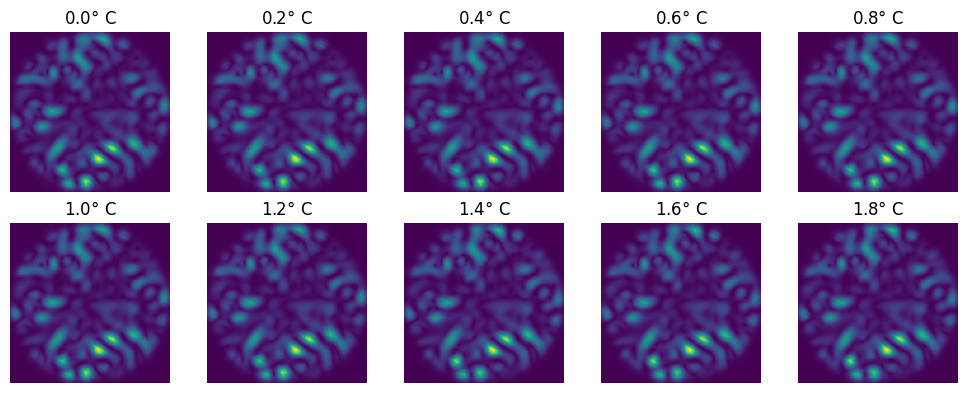

In [25]:
plt.figure(figsize=(10,4))
for i in range(10):
    plt.subplot(2, 5, 1 + i)
    image_tensor, temperature = dataset[i]
    image_np = image_tensor.numpy().squeeze()
    img=plt.imshow(image_np)
    plt.title(f"{temperature.item():.1f}$\degree$ C")
    plt.axis('off')

plt.tight_layout()
plt.show()

### Define Model

In [26]:
# Create a DataLoader
batch_size = 8
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self._batch_size    = batch_size
        self._n_features_in = np.prod(dataset[0].shape[1:]) # get the size of a feature

        # Layers used in architecture
        
        self._flatten       = torch.nn.Flatten()            # flatten to (N, F), where F is the size of the # of input features
        
        # Layers used for contrastive regression


    def forward(self, X):
        return 